# Proyecto 1 - Visión por Computadora
## Ejercicio 1
## Integrantes:

- Javier Alvarado - 21188
- Mario Guerra - 21008
- Emilio Solano - 21212

### Binarización con Otsu

In [4]:
# Importar módulos y librerías para la binarización y métricas
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage import io, filters, morphology, exposure
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [5]:
# Método para cargar imágenes PGM
def load_images(image_path):
    images = []
    filenames = []
    
    # Seleccionar solo archivos PGM numerados del 1 al 20
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.pgm') and not f.endswith('_gt.pgm') and f.split('.')[0].isdigit() and 1 <= int(f.split('.')[0]) <= 20], key=lambda x: int(x.split('.')[0]))
    
    for img_file in image_files:
        img = io.imread(os.path.join(image_path, img_file), as_gray=True)  # Cargar imagen en escala de grises
        images.append(img)
        filenames.append(img_file)
    
    return images, filenames

In [6]:
def preprocess_image(image):
    # Corrección de iluminación con filtro gaussiano
    gaussian_blur = filters.gaussian(image, sigma=10)
    corrected = image - gaussian_blur  # Reduce sombras

    # Normalizar imagen
    corrected = (corrected - corrected.min()) / (corrected.max() - corrected.min())
    
    # Ecualización adaptativa del histograma
    enhanced = exposure.equalize_adapthist(corrected)
    
    return enhanced

In [7]:
def otsu_binarization(image):
    threshold = threshold_otsu(image)
    binary = image < threshold  # Otsu segmenta en blanco y negro
    
    return binary

In [8]:
def postprocess_image(binary_image):
    # Remover objetos con opening
    opened = morphology.opening(binary_image, morphology.disk(1))
    
    # Aplicar closing para conectar estructuras
    closed = morphology.closing(opened, morphology.disk(3))
    
    return closed

In [9]:
def evaluate_metrics(original, binary):
    orig_flat = (original.flatten() < np.median(original)).astype(int)  # Umbral basado en mediana
    bin_flat = binary.flatten().astype(int)

    accuracy = accuracy_score(orig_flat, bin_flat)
    precision = precision_score(orig_flat, bin_flat, zero_division=1)
    recall = recall_score(orig_flat, bin_flat, zero_division=1)
    f1 = f1_score(orig_flat, bin_flat, zero_division=1)
    
    tn, fp, fn, tp = confusion_matrix(orig_flat, bin_flat).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return accuracy, precision, recall, specificity, f1

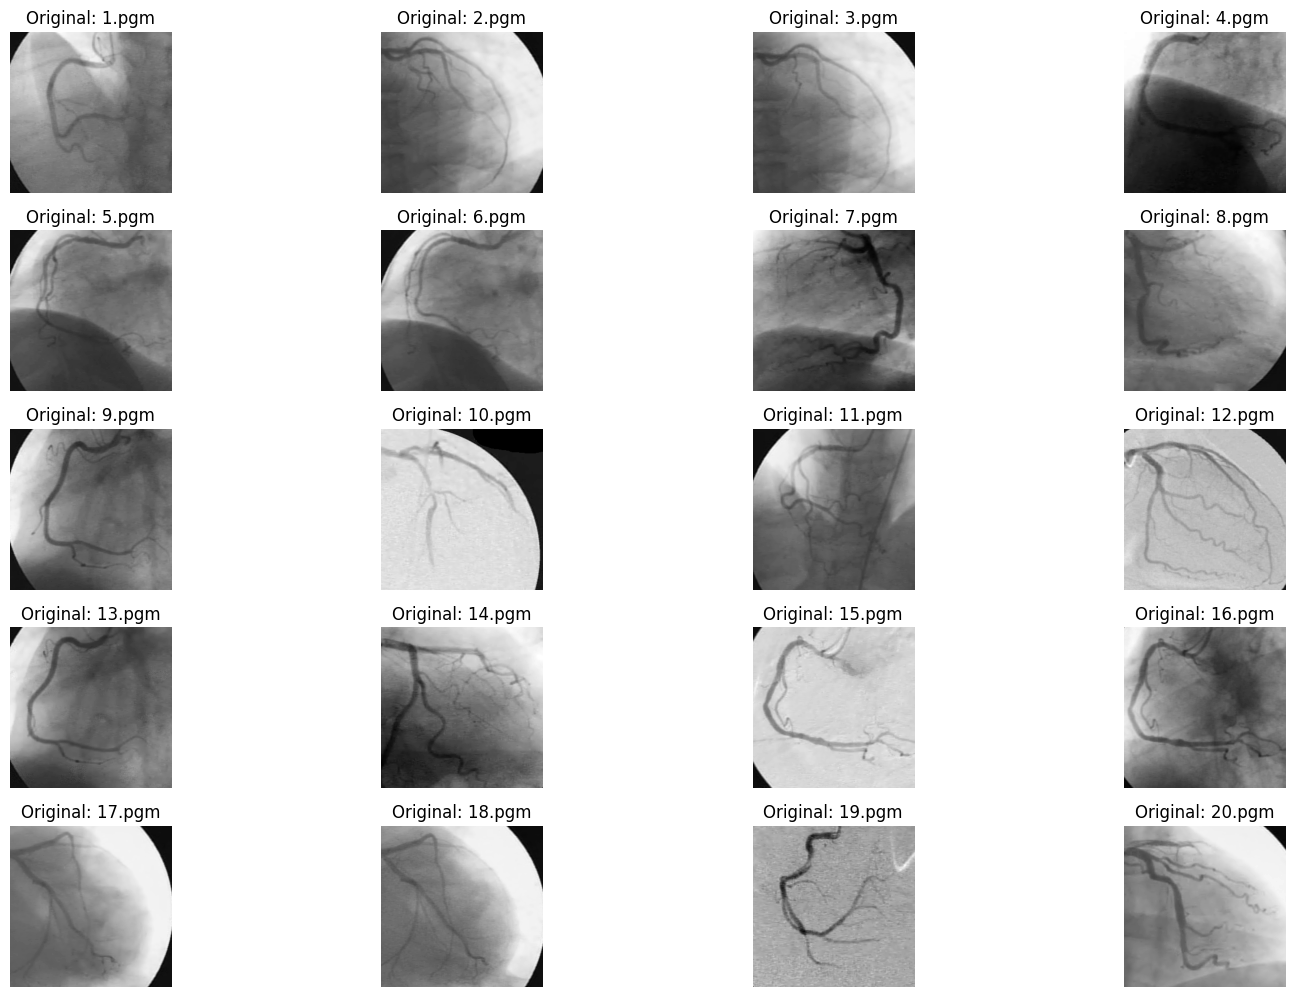

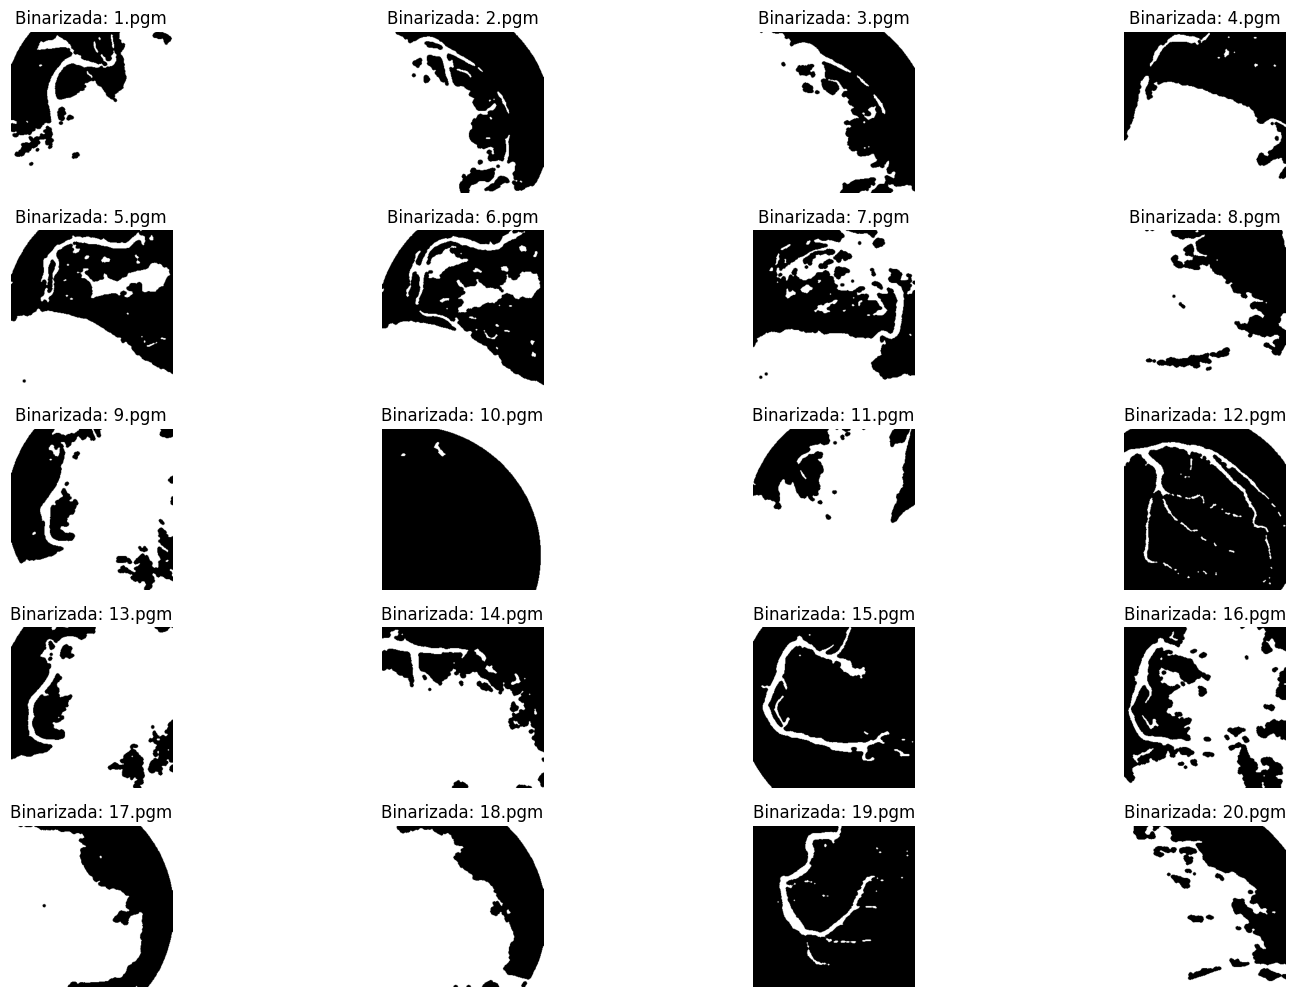

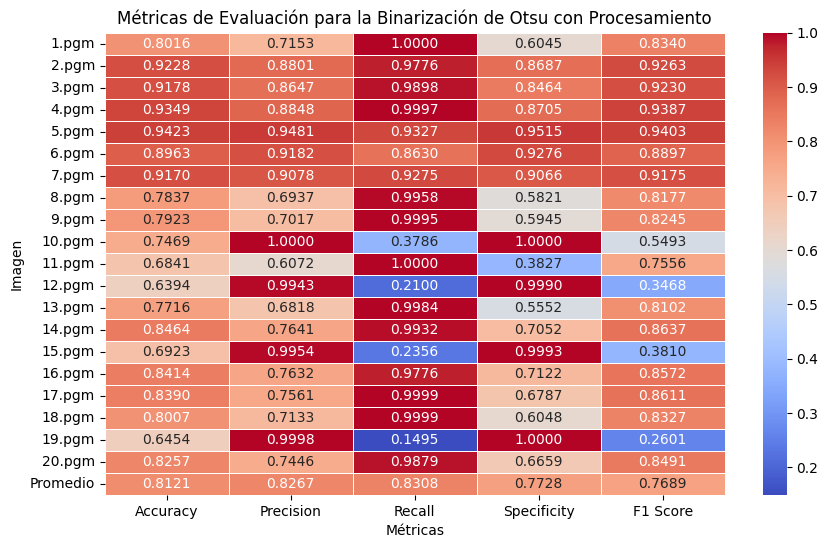

In [10]:
image_path = 'data/database'  # Ruta donde están las imágenes

# Cargar imágenes y aplicar binarización de Otsu
images, filenames = load_images(image_path)
preprocessed_images = [preprocess_image(img) for img in images]
binarized_images = [otsu_binarization(img) for img in preprocessed_images]
processed_results = [postprocess_image(img) for img in binarized_images]

# Mostrar imágenes originales primero y luego las binarizadas
plt.figure(figsize=(15, 20))
for i, (orig_img, fname) in enumerate(zip(images, filenames)):
    plt.subplot(10, 4, i + 1)
    plt.imshow(orig_img, cmap='gray')
    plt.title(f"Original: {fname}")
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 20))
for i, (bin_img, fname) in enumerate(zip(processed_results, filenames)):
    plt.subplot(10, 4, i + 1)
    plt.imshow(bin_img, cmap='gray')
    plt.title(f"Binarizada: {fname}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Evaluar métricas en las 20 imágenes
evaluation_results = [evaluate_metrics(img, bin_img) for img, bin_img in zip(images, processed_results)]

# Crear DataFrame con métricas
columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
df_results = pd.DataFrame(evaluation_results, columns=columns, index=filenames)

# Agregar fila de promedios
df_results.loc["Promedio"] = df_results.mean()

# Mostrar tabla de resultados con estilo
plt.figure(figsize=(10, 6))
sns.heatmap(df_results, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.title("Métricas de Evaluación para la Binarización de Otsu con Procesamiento")
plt.xlabel("Métricas")
plt.ylabel("Imagen")
plt.show()

### Binarización con Sauvola

In [ ]:
# Uso de threshold de Sauvola para binarización
def sauvola_binarization(image, window_size=25, k=0.2):
    threshold = threshold_sauvola(image, window_size=window_size, k=k)
    binary = image < threshold
    
    return binary

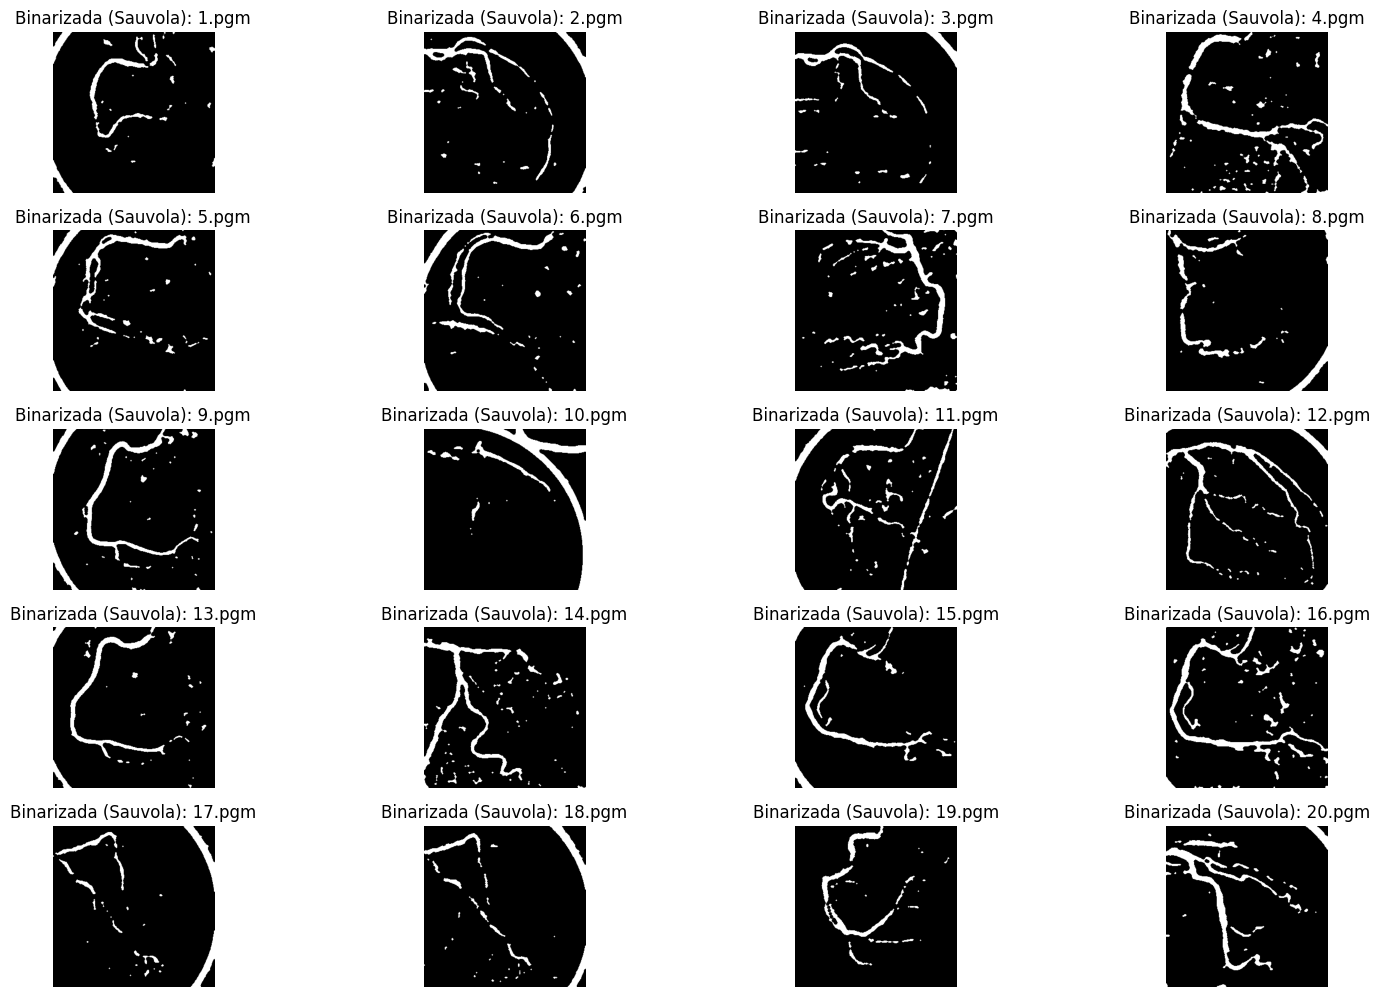

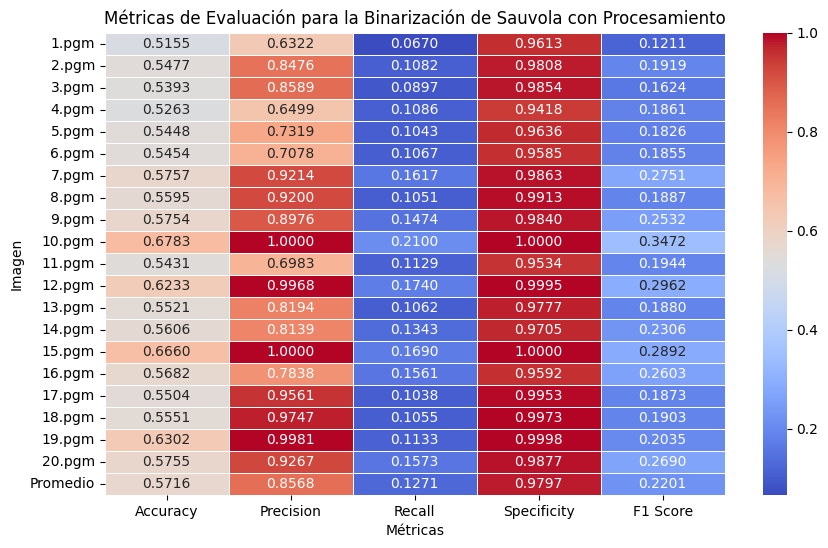

In [ ]:
image_path = 'data/database'  # Ruta con las imágenes

images, filenames = load_images(image_path)
preprocessed_images = [preprocess_image(img) for img in images]

# Binarización con Sauvola
binarized_images_sauvola = [sauvola_binarization(img) for img in preprocessed_images]
processed_results_sauvola = [postprocess_image(img) for img in binarized_images_sauvola]

# Mostrar imágenes binzarizadas con Sauvola
for i, (bin_img, fname) in enumerate(zip(processed_results_sauvola, filenames)):
    plt.subplot(10, 4, i + 1)
    plt.imshow(bin_img, cmap='gray')
    plt.title(f"Binarizada (Sauvola): {fname}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Evaluar métricas
evaluation_results_sauvola = [evaluate_metrics(img, bin_img) for img, bin_img in zip(images, processed_results_sauvola)]

# Crear DataFrame con métricas
columns = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score']
df_results_sauvola = pd.DataFrame(evaluation_results_sauvola, columns=columns, index=filenames)

# Agregar fila de promedios
df_results_sauvola.loc["Promedio"] = df_results_sauvola.mean()

# Mostrar tabla de resultados
plt.figure(figsize=(10, 6))
sns.heatmap(df_results_sauvola, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.title("Métricas de Evaluación para la Binarización de Sauvola con Procesamiento")
plt.xlabel("Métricas")
plt.ylabel("Imagen")
plt.show()